In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive2/')

Mounted at /content/drive2/


# Import the Dataset

In [ ]:
#Try new smaller cats vs dogs dataset

import tensorflow_datasets as tfds

data, ds_info = tfds.load(name = "cats_vs_dogs",
                                             data_dir = "/content/drive2/MyDrive/food-101_data",
                                            shuffle_files = True,
                                            as_supervised = True, # returns data set in tuple form
                                             with_info = True) # returns metadata

def preprocess_image(image, label):
  image = tf.image.resize(image, [128,128], preserve_aspect_ratio=True) # scales images down or up to 128x128 while preserving the aspect ratio
  image = tf.image.resize_with_crop_or_pad(image, 128, 128) # adds padding to any image that is not 128x128 so it fits the dimensionality requirements
  image = tf.cast(image, tf.float32) / 255 # normalizes images so color value pixel range is between 0 and 1
  label = tf.one_hot(label, 2) # One hot encodes the label, 1 indicates the image belongs to the class, the depth is 2 whis is the number of classes
  return image, label

dataset = data['train'].map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).cache()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /content/drive2/MyDrive/food-101_data/cats_vs_dogs/incomplete.5R0PXX_4.0.1/cats_vs_dogs-train.tfreco…

Dataset cats_vs_dogs downloaded and prepared to /content/drive2/MyDrive/food-101_data/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
train_split_ratio = 0.8
num_examples = ds_info.splits['train'].num_examples
num_train = int(train_split_ratio * num_examples)


# Shuffle and split the data
dataset = dataset.shuffle(buffer_size=1000, seed=42)
train_data = dataset.take(num_train).cache()
test_data = dataset.skip(num_train).cache()


In [ ]:
batch_size = 8  # Adjust based on available memory

train_data = train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Visualize Data

In [ ]:
for image, label in train_data.take(1):
    print(f"Image shape: {image.shape}, Label: {label}")

Image shape: (8, 128, 128, 3), Label: [[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


## View Image features

In [ ]:
import os
# Select some images
sample_images = os.listdir("/content/drive2/MyDrive/food-101_data/cats_vs_dogs/4.0.1")
for file in sample_images:
  print(file)

cats_vs_dogs-train.tfrecord-00000-of-00016
cats_vs_dogs-train.tfrecord-00001-of-00016
cats_vs_dogs-train.tfrecord-00002-of-00016
cats_vs_dogs-train.tfrecord-00003-of-00016
cats_vs_dogs-train.tfrecord-00004-of-00016
cats_vs_dogs-train.tfrecord-00005-of-00016
cats_vs_dogs-train.tfrecord-00006-of-00016
cats_vs_dogs-train.tfrecord-00007-of-00016
cats_vs_dogs-train.tfrecord-00008-of-00016
cats_vs_dogs-train.tfrecord-00009-of-00016
cats_vs_dogs-train.tfrecord-00010-of-00016
cats_vs_dogs-train.tfrecord-00011-of-00016
cats_vs_dogs-train.tfrecord-00012-of-00016
cats_vs_dogs-train.tfrecord-00013-of-00016
cats_vs_dogs-train.tfrecord-00014-of-00016
cats_vs_dogs-train.tfrecord-00015-of-00016
features.json
label.labels.txt
dataset_info.json




*   Image shape is height, width, color channels (red, green, blue)
*   This shows us that the images do not have a uniform width or height but they do have a uniform amount of color channels

In [ ]:
# confirm uniform color channels
check_color_channels = data['train'].take(1000)
for image in check_color_channels:
  if image[0].shape[2] != 3:
    print("Image has different amount of color channels")

In [ ]:
# View an image
import matplotlib.pyplot as plt

my_image = data['train'].take(1) # retrieves the first sample from a random class
for aspect in my_image:
  img = aspect[0]
  label = aspect[1]

# View image class
if label == 1:
  label = 'dog'
else:
  label = 'cat'
print(label)
# This returns which food class the randomly selected image belongs too

cat


(-0.5, 483.5, 420.5, -0.5)

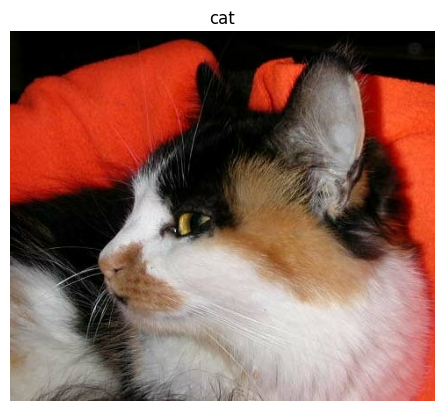

In [ ]:
# show the image and the class it belongs to
plt.imshow(img)
plt.title(label)
plt.axis("off")

## Create a function to display a random image

In [ ]:
def rand_image(dataset):
  my_image = dataset.take(1) # retrieves the first sample from a random class
  for image, label in my_image:
    img = image[0]
    label = label[0]

  index = np.argmax(label)


  if index == 0:
    label = 'cat'
  else:
    label = 'dog'

  plt.imshow(img)
  plt.title(label)
  plt.axis("off")

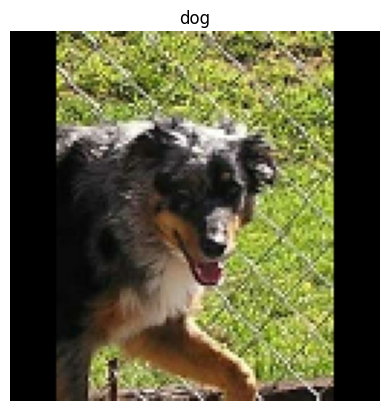

In [ ]:
rand_image(train_data)

#Preprocessing Images

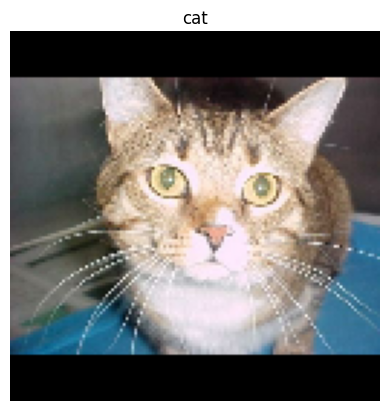

In [ ]:
# View random preprocessed image from train set
rand_image(train_data)

#Pass the data to the MobileNetV2 model


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Create model
from tensorflow.keras import layers, models
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax') # 2 is one for each class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Fit the model
history = model.fit(train_data,
                    validation_data = test_data,
                      epochs = 5)

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 185s 52ms/step - accuracy: 0.8480 - loss: 0.3749 - val_accuracy: 0.8674 - val_loss: 0.5802


--------------------------------------------------------------------------------

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image Data Generator helps with augmentation by expanding the dataset and help train the model further

train_datagen = ImageDataGenerator(
    rescale=.1/255,                           # random scaling of pixel from 0 to 1
    rotation_range=35,                        # randomly rotates the image up to 35 degrees
    height_shift_range = 0.15,                # randomly shifts images vertically by up to 15%
    width_shift_range = 0.15,                 # randomly shifts images horizontally by up to 15%
    shear_range = 0.15,                       # randomly shears (distorts) an image by up to 15%
    zoom_range = 0.10,                        # randomly zooms on the image by up to 10% zoom
    horizontal_flip = True                    # randomly flips some images (will not be done vertically as it makes it upside down)
    fill_mode = 'nearest'                     # fill any missing pixels that may have been removed from transformations
)

# for validation, no transformations will be done to avoid augmentation. It should validate only the original dataset that are unmodified
validation_datagen = ImageDataGenerator(rescale=1./255)